<a href="https://colab.research.google.com/github/mithlohar144/Air_Quality_Prediction_System/blob/main/milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Required Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import joblib
import warnings
warnings.filterwarnings('ignore')


# modal
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import xgboost as xgb

## Load dataset


In [23]:
df = pd.read_csv('/content/data.csv', encoding='latin-1')
df = df.sort_index()
df.head()

target_col = "pm2_5"
data = df[[target_col]].dropna()


train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

## Arima Modal

In [24]:
arima_modal = ARIMA(train.values, order=(3, 1, 2)) # Convert train to numpy array
arima_modal_fit = arima_modal.fit()
arima_forecast = arima_modal_fit.forecast(steps=len(test))

mea_arima = mean_absolute_error(test, arima_forecast)
rmse_arima = mean_squared_error(test, arima_forecast) # Removed np.sort

print(f"Arima = MAE: {mea_arima:.3f}, RMSE: {np.sqrt(rmse_arima):.3f}") # Calculate RMSE from MSE

Arima = MAE: 21.772, RMSE: 30.061


In [25]:
# Create a DataFrame for the evaluation metrics
metrics_data = {'Metric': ['MAE', 'RMSE'],
                'ARIMA': [mea_arima, np.sqrt(rmse_arima)]}
metrics_df = pd.DataFrame(metrics_data)

# Display the table
display(metrics_df)

,Metric,ARIMA
0,MAE,21.771774
1,RMSE,30.061075


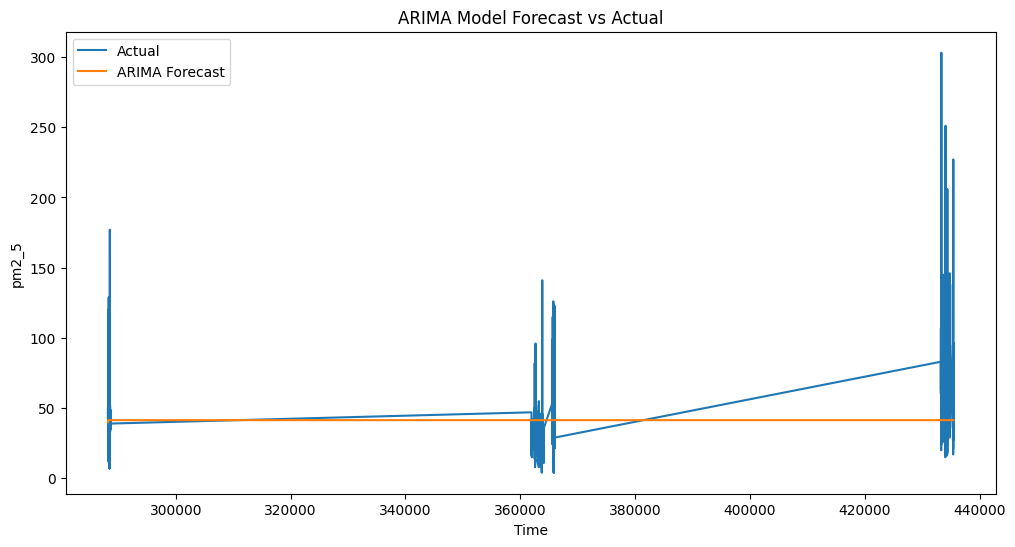

In [26]:
# Visualize the forecast
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.title('ARIMA Model Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel(target_col)
plt.legend()
plt.show()

## Prophet Modal

In [27]:
prophet_df = df[['date', target_col]].dropna().copy() # Add .copy() to avoid SettingWithCopyWarning
prophet_df.columns = ['ds', 'y']
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], errors='coerce') # Use errors='coerce' to handle unparseable dates

# Drop rows where date conversion failed and also where the target column is NaN
prophet_df.dropna(subset=['ds', 'y'], inplace=True)


train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

# Check if test_prophet is empty
if test_prophet.empty:
    mea_prophet = np.nan
    rmse_prophet = np.nan
    print("Prophet test set is empty. Skipping forecast and metric calculation.")
else:
    prophet_model = Prophet()
    prophet_model.fit(train_prophet) # Fit on training data

    # Include history when making future dataframe and then filter for test dates
    future = prophet_model.make_future_dataframe(periods=len(test_prophet), include_history=True)
    forecast = prophet_model.predict(future)

    # Filter forecast to include only the dates present in the test set
    forecast_test = forecast[forecast['ds'].isin(test_prophet['ds'])]

    # Align forecast with test_prophet for metric calculation
    # Ensure both DataFrames have the same 'ds' column for merging
    # Use a left merge from test_prophet to forecast_test to keep all test dates if available
    forecast_aligned = pd.merge(test_prophet.reset_index(drop=True), forecast_test[['ds', 'yhat']], on='ds', how='left')


    # Drop rows with NaN values in 'yhat' before calculating metrics (in case some test dates were not in forecast)
    forecast_aligned.dropna(subset=['yhat'], inplace=True)

    # Check if forecast_aligned is empty after dropping NaNs
    if not forecast_aligned.empty:
        mea_prophet = mean_absolute_error(forecast_aligned['y'].values, forecast_aligned['yhat'].values)
        rmse_prophet = np.sqrt(mean_squared_error(forecast_aligned['y'].values, forecast_aligned['yhat'].values))
        print(f"prophet = MAE: {mea_prophet:.3f}, RMSE: {rmse_prophet:.3f}")
    else:
        mea_prophet = np.nan
        rmse_prophet = np.nan
        print(f"Prophet forecast alignment resulted in an empty DataFrame for metric calculation.")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/1fj787bz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/_67cn34d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63101', 'data', 'file=/tmp/tmpaisvhpv5/1fj787bz.json', 'init=/tmp/tmpaisvhpv5/_67cn34d.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model03cdidau/prophet_model-20251028125557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:55:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:55:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


prophet = MAE: 20.855, RMSE: 29.782


## LSTM Modal

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

n_input = 10
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=16)

lstm_modal = Sequential([
    LSTM(100, activation='relu', input_shape=(n_input, n_features)),
    Dense(1)
])

lstm_modal.compile(optimizer='adam', loss='mse')
lstm_modal.fit(generator, epochs=50)


predictons = []
batch = train_scaled[-n_input:].reshape((1, n_input, n_features))
for i in range(len(test)):
  pred = lstm_modal.predict(batch, verbose=0)[0]
  predictons.append(pred)
  batch = np.append(batch[:, 1:, :], [[pred]], axis=1)

lstm_forecast = scaler.inverse_transform(predictons).ravel()
mea_lstm = mean_absolute_error(test[target_col].values, lstm_forecast)
rmse_lstm = np.sqrt(mean_squared_error(test[target_col].values, lstm_forecast))

print(f"LSTM = MAE: {mea_lstm:.3f}, RMSE: {rmse_lstm:.3f}")

Epoch 1/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0025 
Epoch 2/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0016
Epoch 3/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0018
Epoch 4/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0013
Epoch 5/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0018
Epoch 6/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0013
Epoch 7/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0015
Epoch 8/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0022
Epoch 9/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016
Epoch 10/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0016
Epoch 11/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0016
Epoch 12/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0025
Epoch 13/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0017
Epoch 14/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0015
Epoch 15/50
466/466 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step 

## XGBoost with log feature

In [29]:
def create_log_features(df, n_logs=5):
  for i in range(1, n_logs + 1):
    df[f'log_{i}'] = df[target_col].shift(i)
  return df.dropna()


xgb_data = create_log_features(data.copy(), 5)
X = xgb_data.drop(columns=[target_col])
y = xgb_data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

xgb_modal = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200)
xgb_modal.fit(X_train, y_train)

xgb_pred = xgb_modal.predict(X_test)
mea_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))

print(f"XGBoost = MAE: {mea_xgb:.3f}, RMSE: {rmse_xgb:.3f}")

XGBoost = MAE: 13.935, RMSE: 21.758


## Modal Comparison

In [30]:
results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'LSTM', 'XGBoost'],
    'MAE': [mea_arima, mea_prophet, mea_lstm, rmse_xgb],
    'RMSE': [rmse_arima, rmse_prophet, rmse_lstm, rmse_xgb]
}).sort_values(by="RMSE")

print("\nModal Comparison:\n", results)

best_modal = results.iloc[0]["Model"]
print("\nBest Modal:", best_modal)

# save best modal
if best_modal == "ARIMA":
  joblib.dump(arima_modal_fit, 'best_arima_modal.pkl')
elif best_modal == "Prophet":
  joblib.dump(prophet_model, 'best_prophet_modal.pkl')
elif best_modal == "LSTM":
  joblib.dump(lstm_modal, 'best_lstm_modal.pkl')
else:
  joblib.dump(xgb_modal, 'best_xgb_modal.pkl')


print("\nBest modal saved success.")


Modal Comparison:
      Model        MAE        RMSE
3  XGBoost  21.757510   21.757510
1  Prophet  20.854647   29.781931
2     LSTM  28.221214   39.519137
0    ARIMA  21.771774  903.668210

Best Modal: XGBoost

Best modal saved success.



 Modal Comparison:
      Model        MAE        RMSE
3  XGBoost  21.757510   21.757510
1  Prophet  20.854647   29.781931
2     LSTM  28.221214   39.519137
0    ARIMA  21.771774  903.668210

Best Modal: XGBoost


NameError: name 'prophet_forecast_value' is not defined

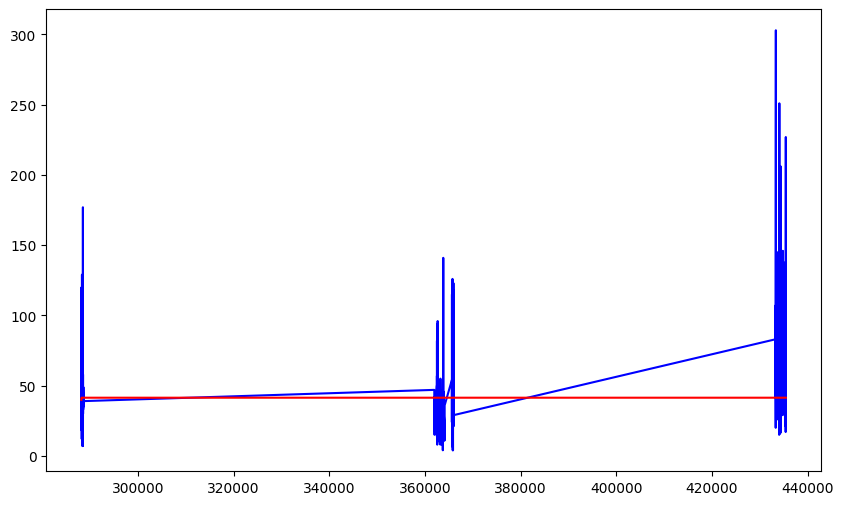

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error


results = pd.DataFrame({
    "Model": ["ARIMA", "Prophet", "LSTM", "XGBoost"],
    "MAE": [mea_arima, mea_prophet, mea_lstm, rmse_xgb],
    "RMSE": [rmse_arima, rmse_prophet, rmse_lstm, rmse_xgb]
}).sort_values(by="RMSE")

print("\n Modal Comparison:\n",results)


best_modal = results.iloc[0]["Model"]
print(f"\nBest Modal: {best_modal}") # Corrected f-string

plt.figure(figsize=(10, 6))
plt.plot(test.index, test[target_col], label="Actual", color="blue")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast", color="red")
plt.plot(test.index, prophet_forecast_value, label="Prophet Forecast", color="green")
plt.plot(test.index, lstm_forecast, label="LSTM Forecast", color="orange")
plt.plot(y_test.index, xgb_pred, label="XGBoost Forecast", color="purple") # Plotting xgb_pred against y_test.index
plt.title("Modal Comparison")
plt.xlabel("Time")
plt.ylabel(target_col)
plt.legend()
plt.show()

## model trained according location.

In [33]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import joblib
import warnings
warnings.filterwarnings('ignore')


# Dictionary to store results for each location
location_results = {}
location_forecasts = {}

# Iterate through each unique location
for location in df['location'].unique():
    print(f"\n--- Processing data for {location} ---")

    # Filter data for the current location and handle missing values
    sub_df = df[df['location'] == location].copy()
    location_data = sub_df[[target_col]].dropna()

    # Skip if not enough data points for time series analysis
    if len(location_data) < 20: # Minimum number of data points, adjust as needed
        print(f"Skipping {location}: Not enough data ({len(location_data)} data points)")
        continue

    # Split data into train and test sets
    train_size = int(len(location_data) * 0.8)
    train = location_data.iloc[:train_size]
    test = location_data.iloc[train_size:]

    # Skip if train or test set is empty
    if len(train) == 0 or len(test) == 0:
        print(f"Skipping {location}: Empty train or test set")
        continue

    # --- ARIMA Model ---
    try:
        print(f"Training ARIMA for {location}")
        arima_modal = ARIMA(train.values, order=(3, 1, 2))
        arima_modal_fit = arima_modal.fit()
        arima_forecast = arima_modal_fit.forecast(steps=len(test))
        mea_arima = mean_absolute_error(test, arima_forecast)
        rmse_arima = np.sqrt(mean_squared_error(test, arima_forecast))
        print(f"ARIMA for {location} - MAE: {mea_arima:.3f}, RMSE: {rmse_arima:.3f}")
    except Exception as e:
        print(f"ARIMA training failed for {location}: {e}")
        mea_arima, rmse_arima = np.nan, np.nan
        arima_forecast = np.full(len(test), np.nan)


    # --- Prophet Model ---
    try:
        print(f"Training Prophet for {location}")
        prophet_df = sub_df[['date', target_col]].dropna().copy()
        prophet_df.columns = ['ds', 'y']
        prophet_df['ds'] = pd.to_datetime(prophet_df['ds'], errors='coerce')

        prophet_df.dropna(subset=['ds', 'y'], inplace=True)

        train_prophet = prophet_df.iloc[:train_size]
        test_prophet = prophet_df.iloc[train_size:]

        prophet_model = Prophet()
        prophet_model.fit(train_prophet)
        future = prophet_model.make_future_dataframe(periods=len(test_prophet), include_history=True)
        forecast = prophet_model.predict(future)

        forecast_aligned = pd.merge(test_prophet.reset_index(drop=True), forecast[['ds', 'yhat']], on='ds', how='left')
        forecast_aligned.dropna(inplace=True)

        if not forecast_aligned.empty:
            mea_prophet = mean_absolute_error(forecast_aligned['y'].values, forecast_aligned['yhat'].values)
            rmse_prophet = np.sqrt(mean_squared_error(forecast_aligned['y'].values, forecast_aligned['yhat'].values))
            print(f"Prophet for {location} - MAE: {mea_prophet:.3f}, RMSE: {rmse_prophet:.3f}")
            prophet_forecast_values = forecast_aligned['yhat'].values # Store aligned forecast values
        else:
            mea_prophet = np.nan
            rmse_prophet = np.nan
            prophet_forecast_values = np.full(len(test), np.nan) # Fill with nan if no aligned forecast
            print(f"Prophet forecast alignment resulted in an empty DataFrame for metric calculation.")
    except Exception as e:
        print(f"Prophet training failed for {location}: {e}")
        mea_prophet, rmse_prophet = np.nan, np.nan
        prophet_forecast_values = np.full(len(test), np.nan) # Fill with nan on error


    # --- LSTM Model ---
    try:
        print(f"Training LSTM for {location}")
        scaler = MinMaxScaler()
        scaled_location_data = scaler.fit_transform(location_data)

        n_input = 12 # Ensure n_input is not larger than train_size
        if train_size < n_input:
             print(f"Skipping LSTM for {location}: Not enough data for LSTM with n_input={n_input}")
             mea_lstm, rmse_lstm = np.nan, np.nan
             lstm_forecast = np.full(len(test), np.nan)
        else:
            train_scaled = scaled_location_data[:train_size]
            test_scaled = scaled_location_data[train_size:]

            # Adjust test_generator data to include n_input look-back
            test_data_for_generator = scaled_location_data[train_size - n_input:]

            train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)
            # Corrected the test_generator to have data and targets of the same length
            test_generator = TimeseriesGenerator(test_data_for_generator, scaled_location_data[train_size:], length=n_input, batch_size=1)

            lstm_modal = Sequential([
                LSTM(100, activation='relu', input_shape=(n_input, n_features)),
                Dense(1)
            ])
            lstm_modal.compile(optimizer='adam', loss='mse')
            # Fit on train_generator
            lstm_modal.fit(train_generator, epochs=20, verbose=0) # Reduced epochs and verbose for speed

            # Predict using the test_generator
            lstm_predictions_scaled = lstm_modal.predict(test_generator)
            lstm_forecast = scaler.inverse_transform(lstm_predictions_scaled).ravel()

            # Ensure lstm_forecast has the same length as the actual test set
            if len(lstm_forecast) == len(test):
                mea_lstm = mean_absolute_error(test.values, lstm_forecast)
                rmse_lstm = np.sqrt(mean_squared_error(test.values, lstm_forecast))
                print(f"LSTM for {location} - MAE: {mea_lstm:.3f}, RMSE: {rmse_lstm:.3f}")
            else:
                 print(f"LSTM forecast length mismatch for {location}. Expected {len(test)}, got {len(lstm_forecast)}")
                 mea_lstm, rmse_lstm = np.nan, np.nan
                 lstm_forecast = np.full(len(test), np.nan)


    except Exception as e:
        print(f"LSTM training failed for {location}: {e}")
        mea_lstm, rmse_lstm = np.nan, np.nan
        lstm_forecast = np.full(len(test), np.nan)


    # --- XGBoost Model ---
    try:
        print(f"Training XGBoost for {location}")
        def create_log_features(df, n_logs=5):
            for i in range(1, n_logs + 1):
                df[f'log_{i}'] = df[target_col].shift(i)
            return df.dropna()

        xgb_data = create_log_features(location_data.copy(), 5)

        if len(xgb_data) == 0:
             print(f"Skipping XGBoost for {location}: Not enough data after creating lag features")
             mea_xgb, rmse_xgb = np.nan, np.nan
             xgb_pred = np.full(len(test), np.nan)
        else:
            X = xgb_data.drop(columns=[target_col])
            y = xgb_data[target_col]

            # Need to split based on the original train/test split indices to align with other models
            # Find the index in xgb_data that corresponds to the start of the test set in location_data
            start_test_index_in_location_data = test.index[0]
            # Find the corresponding index in xgb_data. If the exact index doesn't exist, find the closest one.
            if start_test_index_in_location_data in xgb_data.index:
                 split_index_xgb = xgb_data.index.get_loc(start_test_index_in_location_data)
            else:
                 # Find the index of the first element in xgb_data that is >= start_test_index_in_location_data
                 split_index_xgb = xgb_data.index.searchsorted(start_test_index_in_location_data)


            X_train, X_test = X.iloc[:split_index_xgb], X.iloc[split_index_xgb:]
            y_train, y_test_xgb = y.iloc[:split_index_xgb], y.iloc[split_index_xgb:] # Renamed y_test to y_test_xgb to avoid conflict


            if len(X_train) == 0 or len(X_test) == 0:
                 print(f"Skipping XGBoost for {location}: Empty train or test set after splitting xgb_data")
                 mea_xgb, rmse_xgb = np.nan, np.nan
                 xgb_pred = np.full(len(test), np.nan)
            else:
                xgb_modal = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, random_state=42) # Added some common parameters
                xgb_modal.fit(X_train, y_train)

                xgb_pred = xgb_modal.predict(X_test)

                # Ensure xgb_pred has the same length as the portion of the test set it corresponds to
                if len(xgb_pred) == len(y_test_xgb):
                    mea_xgb = mean_absolute_error(y_test_xgb, xgb_pred)
                    rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, xgb_pred))
                    print(f"XGBoost for {location} - MAE: {mea_xgb:.3f}, RMSE: {rmse_xgb:.3f}")
                else:
                     print(f"XGBoost prediction length mismatch for {location}. Expected {len(y_test_xgb)}, got {len(xgb_pred)}")
                     mea_xgb, rmse_xgb = np.nan, np.nan
                     xgb_pred = np.full(len(test), np.nan) # Fill with nan to maintain structure



    except Exception as e:
        print(f"XGBoost training failed for {location}: {e}")
        mea_xgb, rmse_xgb = np.nan, np.nan
        xgb_pred = np.full(len(test), np.nan)


    # Store results for the current location
    location_results[location] = {
        'ARIMA_MAE': mea_arima, 'ARIMA_RMSE': rmse_arima,
        'Prophet_MAE': mea_prophet, 'Prophet_RMSE': rmse_prophet,
        'LSTM_MAE': mea_lstm, 'LSTM_RMSE': rmse_lstm,
        'XGBoost_MAE': mea_xgb, 'XGBoost_RMSE': rmse_xgb
    }

    # Store forecasts (aligning indices for easier plotting later)
    # Need to ensure forecast lengths match the test set length for consistent storage
    location_forecasts[location] = {
        'Actual': test[target_col].values, # Store actual test values
        'ARIMA_Forecast': arima_forecast,
        'Prophet_Forecast': prophet_forecast_values, # Use the aligned forecast values
        'LSTM_Forecast': lstm_forecast, # Use the lstm_forecast directly
        'XGBoost_Forecast': xgb_pred, # Use the xgb_pred directly
        'Test_Index': test.index # Store the index of the test set
    }


# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame.from_dict(location_results, orient='index')

print("\n--- Overall Model Performance Across Locations ---")
display(results_df)


--- Processing data for Hyderabad ---
Skipping Hyderabad: Not enough data (0 data points)

--- Processing data for Vishakhapatnam ---
Skipping Vishakhapatnam: Not enough data (0 data points)

--- Processing data for Visakhapatnam ---
Skipping Visakhapatnam: Not enough data (0 data points)

--- Processing data for Tirupati ---
Skipping Tirupati: Not enough data (0 data points)

--- Processing data for Vijayawada ---
Skipping Vijayawada: Not enough data (0 data points)

--- Processing data for Patancheru ---
Skipping Patancheru: Not enough data (0 data points)

--- Processing data for Ramagundam ---
Skipping Ramagundam: Not enough data (0 data points)

--- Processing data for Kurnool ---
Skipping Kurnool: Not enough data (0 data points)

--- Processing data for Guntur ---
Skipping Guntur: Not enough data (0 data points)

--- Processing data for Nalgonda ---
Skipping Nalgonda: Not enough data (0 data points)

--- Processing data for Nellore ---
Skipping Nellore: Not enough data (0 data p

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/1f84rem5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/_degq5up.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84919', 'data', 'file=/tmp/tmpaisvhpv5/1f84rem5.json', 'init=/tmp/tmpaisvhpv5/_degq5up.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelxtg653t1/prophet_model-20251028130329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Sangareddy - MAE: 37.414, RMSE: 42.475
Training Prophet for Sangareddy
Prophet for Sangareddy - MAE: 50.761, RMSE: 54.580
Training LSTM for Sangareddy
LSTM training failed for Sangareddy: Data and targets have to be of same length. Data length is 83 while target length is 71
Training XGBoost for Sangareddy
XGBoost for Sangareddy - MAE: 20.745, RMSE: 25.564

--- Processing data for Srikakulam ---
Skipping Srikakulam: Not enough data (0 data points)

--- Processing data for Vizianagaram ---
Skipping Vizianagaram: Not enough data (0 data points)

--- Processing data for Itanagar ---
Skipping Itanagar: Not enough data (0 data points)

--- Processing data for Naharlagun ---
Skipping Naharlagun: Not enough data (0 data points)

--- Processing data for Guwahati ---
Skipping Guwahati: Not enough data (0 data points)

--- Processing data for Bongaigaon ---
Skipping Bongaigaon: Not enough data (0 data points)

--- Processing data for Dibrugarh ---
Skipping Dibrugarh: Not enough data (0

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Skipping Bilaspur: Not enough data (0 data points)

--- Processing data for Daman ---
Training ARIMA for Daman
ARIMA for Daman - MAE: 5.474, RMSE: 5.820
Training Prophet for Daman


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/il29isv9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/9zafa1gq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7132', 'data', 'file=/tmp/tmpaisvhpv5/il29isv9.json', 'init=/tmp/tmpaisvhpv5/9zafa1gq.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model0pbg688_/prophet_model-20251028130331.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Daman - MAE: 6.048, RMSE: 6.446
Training LSTM for Daman
LSTM training failed for Daman: Data and targets have to be of same length. Data length is 21 while target length is 9
Training XGBoost for Daman
XGBoost for Daman - MAE: 6.496, RMSE: 6.857

--- Processing data for Silvassa ---
Skipping Silvassa: Not enough data (0 data points)

--- Processing data for Khadoli ---
Training ARIMA for Khadoli


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/m4vbp5la.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/kpavyn24.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75087', 'data', 'file=/tmp/tmpaisvhpv5/m4vbp5la.json', 'init=/tmp/tmpaisvhpv5/kpavyn24.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modeli198_qhi/prophet_model-20251028130331.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Khadoli - MAE: 3.065, RMSE: 3.540
Training Prophet for Khadoli
Prophet for Khadoli - MAE: 3.622, RMSE: 4.031
Training LSTM for Khadoli
LSTM training failed for Khadoli: Data and targets have to be of same length. Data length is 21 while target length is 9
Training XGBoost for Khadoli
XGBoost for Khadoli - MAE: 3.095, RMSE: 3.868

--- Processing data for Daman Diu & Nagar ---
Skipping Daman Diu & Nagar: Not enough data (0 data points)

--- Processing data for Delhi ---
Training ARIMA for Delhi


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/2902kdy6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/mipnbkir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65703', 'data', 'file=/tmp/tmpaisvhpv5/2902kdy6.json', 'init=/tmp/tmpaisvhpv5/mipnbkir.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modell29sviac/prophet_model-20251028130332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Delhi - MAE: 47.197, RMSE: 61.178
Training Prophet for Delhi
Prophet for Delhi - MAE: 32.850, RMSE: 41.373
Training LSTM for Delhi
LSTM training failed for Delhi: Data and targets have to be of same length. Data length is 87 while target length is 75
Training XGBoost for Delhi


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/qams4xph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/jx9jl9nf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62461', 'data', 'file=/tmp/tmpaisvhpv5/qams4xph.json', 'init=/tmp/tmpaisvhpv5/jx9jl9nf.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelj98gt4in/prophet_model-20251028130333.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


XGBoost for Delhi - MAE: 36.234, RMSE: 47.067

--- Processing data for Ponda ---
Training ARIMA for Ponda
ARIMA for Ponda - MAE: 4.140, RMSE: 4.926
Training Prophet for Ponda


13:03:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Ponda - MAE: 4.549, RMSE: 6.431
Training LSTM for Ponda
LSTM training failed for Ponda: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Ponda
XGBoost for Ponda - MAE: 3.944, RMSE: 4.965

--- Processing data for Vasco ---
Skipping Vasco: Not enough data (0 data points)

--- Processing data for Panjim ---
Skipping Panjim: Not enough data (0 data points)

--- Processing data for Panaji ---
Skipping Panaji: Not enough data (0 data points)

--- Processing data for Mormugao ---
Skipping Mormugao: Not enough data (0 data points)

--- Processing data for Amona ---
Training ARIMA for Amona


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/3kb_t4up.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/0o_vhd_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46615', 'data', 'file=/tmp/tmpaisvhpv5/3kb_t4up.json', 'init=/tmp/tmpaisvhpv5/0o_vhd_7.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelxg_96uj5/prophet_model-20251028130334.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Amona - MAE: 4.385, RMSE: 4.952
Training Prophet for Amona


13:03:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Amona - MAE: 7.984, RMSE: 8.983
Training LSTM for Amona
LSTM training failed for Amona: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Amona


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/vgf0w4hu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/8usmhlsb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93598', 'data', 'file=/tmp/tmpaisvhpv5/vgf0w4hu.json', 'init=/tmp/tmpaisvhpv5/8usmhlsb.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelkve0x04x/prophet_model-20251028130336.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


XGBoost for Amona - MAE: 4.770, RMSE: 5.688

--- Processing data for Assanora ---
Training ARIMA for Assanora
ARIMA for Assanora - MAE: 3.100, RMSE: 3.733
Training Prophet for Assanora


13:03:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Assanora - MAE: 4.849, RMSE: 6.521
Training LSTM for Assanora
LSTM training failed for Assanora: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Assanora
XGBoost for Assanora - MAE: 4.187, RMSE: 5.341

--- Processing data for Bicholim ---
Training ARIMA for Bicholim


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/bb05clup.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/_aupmvsa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27770', 'data', 'file=/tmp/tmpaisvhpv5/bb05clup.json', 'init=/tmp/tmpaisvhpv5/_aupmvsa.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelp12jdizd/prophet_model-20251028130336.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Bicholim - MAE: 7.796, RMSE: 8.784
Training Prophet for Bicholim


13:03:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Bicholim - MAE: 10.592, RMSE: 12.191
Training LSTM for Bicholim
LSTM training failed for Bicholim: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Bicholim
XGBoost for Bicholim - MAE: 5.508, RMSE: 6.493

--- Processing data for Codli ---
Training ARIMA for Codli


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/q2zbya7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/1m5thsuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73985', 'data', 'file=/tmp/tmpaisvhpv5/q2zbya7y.json', 'init=/tmp/tmpaisvhpv5/1m5thsuz.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelle9q1vx8/prophet_model-20251028130337.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Codli - MAE: 7.449, RMSE: 8.486
Training Prophet for Codli


13:03:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Codli - MAE: 9.855, RMSE: 10.874
Training LSTM for Codli
LSTM training failed for Codli: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Codli
XGBoost for Codli - MAE: 5.723, RMSE: 6.508

--- Processing data for Curchorem ---
Training ARIMA for Curchorem


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/56nw1m5c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/3qmbui91.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49714', 'data', 'file=/tmp/tmpaisvhpv5/56nw1m5c.json', 'init=/tmp/tmpaisvhpv5/3qmbui91.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelenq1_1v5/prophet_model-20251028130337.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Curchorem - MAE: 6.969, RMSE: 8.100
Training Prophet for Curchorem


13:03:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet for Curchorem - MAE: 7.774, RMSE: 9.392
Training LSTM for Curchorem
LSTM training failed for Curchorem: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Curchorem
XGBoost for Curchorem - MAE: 4.030, RMSE: 4.847

--- Processing data for Honda ---
Training ARIMA for Honda
ARIMA for Honda - MAE: 4.441, RMSE: 5.152
Training Prophet for Honda


DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/2bv7gzet.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/0r4ez11_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26638', 'data', 'file=/tmp/tmpaisvhpv5/2bv7gzet.json', 'init=/tmp/tmpaisvhpv5/0r4ez11_.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelgtqwlw__/prophet_model-20251028130338.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Honda - MAE: 3.990, RMSE: 5.252
Training LSTM for Honda
LSTM training failed for Honda: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Honda
XGBoost for Honda - MAE: 6.258, RMSE: 7.226

--- Processing data for Usgao ---
Training ARIMA for Usgao
ARIMA for Usgao - MAE: 5.768, RMSE: 6.340
Training Prophet for Usgao


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/u5rekj1a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/1djwsbjd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16826', 'data', 'file=/tmp/tmpaisvhpv5/u5rekj1a.json', 'init=/tmp/tmpaisvhpv5/1djwsbjd.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelehnyi1mx/prophet_model-20251028130338.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Usgao - MAE: 8.858, RMSE: 9.590
Training LSTM for Usgao
LSTM training failed for Usgao: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Usgao
XGBoost for Usgao - MAE: 2.971, RMSE: 3.541

--- Processing data for Kundaim ---
Training ARIMA for Kundaim


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/sq1i2w4x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/ai_dmjm2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31206', 'data', 'file=/tmp/tmpaisvhpv5/sq1i2w4x.json', 'init=/tmp/tmpaisvhpv5/ai_dmjm2.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelfvczzu5x/prophet_model-20251028130339.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Kundaim - MAE: 6.077, RMSE: 7.112
Training Prophet for Kundaim


13:03:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Kundaim - MAE: 9.411, RMSE: 10.843
Training LSTM for Kundaim
LSTM training failed for Kundaim: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Kundaim
XGBoost for Kundaim - MAE: 4.871, RMSE: 6.161

--- Processing data for Mapusa ---
Training ARIMA for Mapusa


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/lo9j_0st.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/rhaj0cm_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65791', 'data', 'file=/tmp/tmpaisvhpv5/lo9j_0st.json', 'init=/tmp/tmpaisvhpv5/rhaj0cm_.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model19qosl2u/prophet_model-20251028130340.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Mapusa - MAE: 11.896, RMSE: 13.691
Training Prophet for Mapusa


13:03:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Mapusa - MAE: 3.764, RMSE: 4.066
Training LSTM for Mapusa
LSTM training failed for Mapusa: Data and targets have to be of same length. Data length is 23 while target length is 11
Training XGBoost for Mapusa
XGBoost for Mapusa - MAE: 11.273, RMSE: 15.244

--- Processing data for Margao ---
Training ARIMA for Margao


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/lczqewjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/wvx4b2dx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71604', 'data', 'file=/tmp/tmpaisvhpv5/lczqewjb.json', 'init=/tmp/tmpaisvhpv5/wvx4b2dx.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelh3k0n9a2/prophet_model-20251028130342.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Margao - MAE: 7.835, RMSE: 8.877
Training Prophet for Margao


13:03:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Margao - MAE: 7.145, RMSE: 8.828
Training LSTM for Margao
LSTM training failed for Margao: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Margao
XGBoost for Margao - MAE: 5.871, RMSE: 6.830

--- Processing data for Sanguem ---
Training ARIMA for Sanguem


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/34cbgglx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/e6su6z6t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46420', 'data', 'file=/tmp/tmpaisvhpv5/34cbgglx.json', 'init=/tmp/tmpaisvhpv5/e6su6z6t.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelqbi_f3g1/prophet_model-20251028130343.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Sanguem - MAE: 3.405, RMSE: 4.418
Training Prophet for Sanguem


13:03:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Sanguem - MAE: 3.908, RMSE: 4.511
Training LSTM for Sanguem
LSTM training failed for Sanguem: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Sanguem
XGBoost for Sanguem - MAE: 3.243, RMSE: 4.022

--- Processing data for Tilamol ---
Training ARIMA for Tilamol


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/mbyqnju7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/iuhbbm66.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97303', 'data', 'file=/tmp/tmpaisvhpv5/mbyqnju7.json', 'init=/tmp/tmpaisvhpv5/iuhbbm66.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelfw44cs4h/prophet_model-20251028130344.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Tilamol - MAE: 5.629, RMSE: 6.566
Training Prophet for Tilamol


13:03:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet for Tilamol - MAE: 6.406, RMSE: 7.537
Training LSTM for Tilamol
LSTM training failed for Tilamol: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Tilamol
XGBoost for Tilamol - MAE: 3.880, RMSE: 5.285

--- Processing data for Cuncolim ---
Training ARIMA for Cuncolim
ARIMA for Cuncolim - MAE: 3.355, RMSE: 4.345
Training Prophet for Cuncolim


DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/fw5peffz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/7lzrrmv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8330', 'data', 'file=/tmp/tmpaisvhpv5/fw5peffz.json', 'init=/tmp/tmpaisvhpv5/7lzrrmv_.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model2c32l1u8/prophet_model-20251028130344.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Cuncolim - MAE: 3.371, RMSE: 4.615
Training LSTM for Cuncolim
LSTM training failed for Cuncolim: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Cuncolim
XGBoost for Cuncolim - MAE: 4.911, RMSE: 5.694

--- Processing data for Baroda ---
Skipping Baroda: Not enough data (0 data points)

--- Processing data for Surat ---
Training ARIMA for Surat


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/0h6tqlk8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/so11ktsu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65686', 'data', 'file=/tmp/tmpaisvhpv5/0h6tqlk8.json', 'init=/tmp/tmpaisvhpv5/so11ktsu.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelkgpfig1h/prophet_model-20251028130345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Surat - MAE: 3.303, RMSE: 4.142
Training Prophet for Surat
Prophet for Surat - MAE: 3.133, RMSE: 3.953
Training LSTM for Surat
LSTM training failed for Surat: Data and targets have to be of same length. Data length is 68 while target length is 56
Training XGBoost for Surat
XGBoost for Surat - MAE: 3.275, RMSE: 3.974

--- Processing data for Ahmedabad ---
Training ARIMA for Ahmedabad


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/99c61d6o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/9klt87vj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21967', 'data', 'file=/tmp/tmpaisvhpv5/99c61d6o.json', 'init=/tmp/tmpaisvhpv5/9klt87vj.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelsuw9cwpr/prophet_model-20251028130347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Ahmedabad - MAE: 5.091, RMSE: 6.400
Training Prophet for Ahmedabad
Prophet for Ahmedabad - MAE: 3.772, RMSE: 4.586
Training LSTM for Ahmedabad
LSTM training failed for Ahmedabad: Data and targets have to be of same length. Data length is 139 while target length is 127
Training XGBoost for Ahmedabad
XGBoost for Ahmedabad - MAE: 4.637, RMSE: 6.036

--- Processing data for Vapi ---
Training ARIMA for Vapi


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/18s6ntjc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/lffjpoq7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22823', 'data', 'file=/tmp/tmpaisvhpv5/18s6ntjc.json', 'init=/tmp/tmpaisvhpv5/lffjpoq7.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelp1x5108q/prophet_model-20251028130348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Vapi - MAE: 3.051, RMSE: 3.636
Training Prophet for Vapi
Prophet for Vapi - MAE: 2.965, RMSE: 3.597
Training LSTM for Vapi
LSTM training failed for Vapi: Data and targets have to be of same length. Data length is 48 while target length is 36
Training XGBoost for Vapi
XGBoost for Vapi - MAE: 3.512, RMSE: 3.972

--- Processing data for Ankleshwar ---
Training ARIMA for Ankleshwar


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/29xsgr15.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/4q0ocj2n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98544', 'data', 'file=/tmp/tmpaisvhpv5/29xsgr15.json', 'init=/tmp/tmpaisvhpv5/4q0ocj2n.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model1_dxl94k/prophet_model-20251028130349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Ankleshwar - MAE: 2.647, RMSE: 3.132
Training Prophet for Ankleshwar
Prophet for Ankleshwar - MAE: 2.987, RMSE: 3.431
Training LSTM for Ankleshwar
LSTM training failed for Ankleshwar: Data and targets have to be of same length. Data length is 62 while target length is 50
Training XGBoost for Ankleshwar
XGBoost for Ankleshwar - MAE: 3.420, RMSE: 4.409

--- Processing data for Rajkot ---
Training ARIMA for Rajkot


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/id6oy2cs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/9qk77a48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55675', 'data', 'file=/tmp/tmpaisvhpv5/id6oy2cs.json', 'init=/tmp/tmpaisvhpv5/9qk77a48.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modeluentl2vo/prophet_model-20251028130350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Rajkot - MAE: 4.319, RMSE: 5.125
Training Prophet for Rajkot
Prophet for Rajkot - MAE: 4.832, RMSE: 5.838
Training LSTM for Rajkot
LSTM training failed for Rajkot: Data and targets have to be of same length. Data length is 45 while target length is 33
Training XGBoost for Rajkot


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/i_6znmcm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/xu9pf3dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10863', 'data', 'file=/tmp/tmpaisvhpv5/i_6znmcm.json', 'init=/tmp/tmpaisvhpv5/xu9pf3dw.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model4j0jqrv0/prophet_model-20251028130350.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


XGBoost for Rajkot - MAE: 4.678, RMSE: 5.770

--- Processing data for Bharuch ---
Training ARIMA for Bharuch
ARIMA for Bharuch - MAE: 2.503, RMSE: 3.296
Training Prophet for Bharuch


13:03:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Bharuch - MAE: 1.683, RMSE: 1.683
Training LSTM for Bharuch
LSTM training failed for Bharuch: Data and targets have to be of same length. Data length is 22 while target length is 10
Training XGBoost for Bharuch
XGBoost for Bharuch - MAE: 3.829, RMSE: 4.587

--- Processing data for Jamnagar ---
Training ARIMA for Jamnagar


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/a20x6vp8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/3s78fi39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35259', 'data', 'file=/tmp/tmpaisvhpv5/a20x6vp8.json', 'init=/tmp/tmpaisvhpv5/3s78fi39.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelbco81c32/prophet_model-20251028130351.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Jamnagar - MAE: 3.591, RMSE: 4.227
Training Prophet for Jamnagar


13:03:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Jamnagar - MAE: 10.968, RMSE: 11.679
Training LSTM for Jamnagar
LSTM training failed for Jamnagar: Data and targets have to be of same length. Data length is 31 while target length is 19
Training XGBoost for Jamnagar
XGBoost for Jamnagar - MAE: 5.329, RMSE: 7.337

--- Processing data for Vadodara ---
Training ARIMA for Vadodara


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/jmh7dc8p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/35plpt99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42672', 'data', 'file=/tmp/tmpaisvhpv5/jmh7dc8p.json', 'init=/tmp/tmpaisvhpv5/35plpt99.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modeli6hfmkdr/prophet_model-20251028130351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Vadodara - MAE: 2.931, RMSE: 3.769
Training Prophet for Vadodara
Prophet for Vadodara - MAE: 4.296, RMSE: 5.184
Training LSTM for Vadodara
LSTM training failed for Vadodara: Data and targets have to be of same length. Data length is 103 while target length is 91
Training XGBoost for Vadodara
XGBoost for Vadodara - MAE: 3.578, RMSE: 4.450

--- Processing data for Anklesvar ---
Skipping Anklesvar: Not enough data (0 data points)

--- Processing data for ANKLESHWAR ---
Training ARIMA for ANKLESHWAR


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/jxxoo4qq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/kmu63101.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64212', 'data', 'file=/tmp/tmpaisvhpv5/jxxoo4qq.json', 'init=/tmp/tmpaisvhpv5/kmu63101.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelmpegd3hk/prophet_model-20251028130352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for ANKLESHWAR - MAE: 3.157, RMSE: 3.999
Training Prophet for ANKLESHWAR
Prophet for ANKLESHWAR - MAE: 1.594, RMSE: 1.594
Training LSTM for ANKLESHWAR
LSTM training failed for ANKLESHWAR: Data and targets have to be of same length. Data length is 46 while target length is 34
Training XGBoost for ANKLESHWAR
XGBoost for ANKLESHWAR - MAE: 3.370, RMSE: 4.273

--- Processing data for VAPI ---
Training ARIMA for VAPI


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/58yg0twz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/_ur85b20.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64390', 'data', 'file=/tmp/tmpaisvhpv5/58yg0twz.json', 'init=/tmp/tmpaisvhpv5/_ur85b20.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modeln7y_3czx/prophet_model-20251028130352.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:

ARIMA for VAPI - MAE: 3.683, RMSE: 4.444
Training Prophet for VAPI
Prophet for VAPI - MAE: 3.799, RMSE: 3.799
Training LSTM for VAPI
LSTM training failed for VAPI: Data and targets have to be of same length. Data length is 17 while target length is 5
Training XGBoost for VAPI
XGBoost for VAPI - MAE: 3.562, RMSE: 4.634

--- Processing data for Bhuj ---


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 14.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/rmvo6yr8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/__5xx4jw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32912', 'data', 'file=/tmp/tmpaisvhpv5/rmvo6yr8.json', 'init=/tmp/tmpaisvhpv5/__5xx4jw.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelkg2qgepz/prophet_model-20251028130353.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Training ARIMA for Bhuj
ARIMA for Bhuj - MAE: 2.235, RMSE: 2.570
Training Prophet for Bhuj


13:03:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Bhuj - MAE: 5.276, RMSE: 5.276
Training LSTM for Bhuj
LSTM training failed for Bhuj: Data and targets have to be of same length. Data length is 17 while target length is 5
Training XGBoost for Bhuj
XGBoost for Bhuj - MAE: 2.259, RMSE: 2.494

--- Processing data for MORBI ---
Training ARIMA for MORBI


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/m95f8628.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/6f0wd5gd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92734', 'data', 'file=/tmp/tmpaisvhpv5/m95f8628.json', 'init=/tmp/tmpaisvhpv5/6f0wd5gd.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelnznxzcfb/prophet_model-20251028130353.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for MORBI - MAE: 2.300, RMSE: 2.887
Training Prophet for MORBI
Prophet for MORBI - MAE: 0.896, RMSE: 0.896
Training LSTM for MORBI
LSTM training failed for MORBI: Data and targets have to be of same length. Data length is 22 while target length is 10
Training XGBoost for MORBI
XGBoost for MORBI - MAE: 2.895, RMSE: 3.746

--- Processing data for SANAND ---
Training ARIMA for SANAND


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 13.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/4bhgygx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/ns9dqun6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13943', 'data', 'file=/tmp/tmpaisvhpv5/4bhgygx3.json', 'init=/tmp/tmpaisvhpv5/ns9dqun6.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelzvqfgu3c/prophet_model-20251028130354.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:

ARIMA for SANAND - MAE: 4.174, RMSE: 5.899
Training Prophet for SANAND
Prophet for SANAND - MAE: 4.389, RMSE: 4.389
Training LSTM for SANAND
LSTM training failed for SANAND: Data and targets have to be of same length. Data length is 17 while target length is 5
Training XGBoost for SANAND


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


XGBoost for SANAND - MAE: 3.738, RMSE: 4.429

--- Processing data for Sarigam ---
Training ARIMA for Sarigam
ARIMA for Sarigam - MAE: 1.924, RMSE: 2.165
Training Prophet for Sarigam


INFO:prophet:n_changepoints greater than number of observations. Using 14.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/h5qmd8go.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/cx32v5cg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10537', 'data', 'file=/tmp/tmpaisvhpv5/h5qmd8go.json', 'init=/tmp/tmpaisvhpv5/cx32v5cg.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model9gx7zed5/prophet_model-20251028130354.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Sarigam - MAE: 6.394, RMSE: 6.394
Training LSTM for Sarigam
LSTM training failed for Sarigam: Data and targets have to be of same length. Data length is 17 while target length is 5
Training XGBoost for Sarigam
XGBoost for Sarigam - MAE: 3.052, RMSE: 3.082

--- Processing data for Faridabad ---
Skipping Faridabad: Not enough data (0 data points)

--- Processing data for Yamuna Nagar ---
Skipping Yamuna Nagar: Not enough data (0 data points)

--- Processing data for Dharuhera ---
Skipping Dharuhera: Not enough data (0 data points)

--- Processing data for Hisar ---
Skipping Hisar: Not enough data (0 data points)

--- Processing data for Yamunanagar ---
Skipping Yamunanagar: Not enough data (0 data points)

--- Processing data for Shimla ---
Skipping Shimla: Not enough data (0 data points)

--- Processing data for Paonta Sahib ---
Skipping Paonta Sahib: Not enough data (0 data points)

--- Processing data for Parwanoo ---
Skipping Parwanoo: Not enough data (0 data points)

---

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/3g7pp8rf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/yjx02psm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75127', 'data', 'file=/tmp/tmpaisvhpv5/3g7pp8rf.json', 'init=/tmp/tmpaisvhpv5/yjx02psm.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelikoig2sb/prophet_model-20251028130357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Nagda - MAE: 5.405, RMSE: 6.679
Training Prophet for Nagda
Prophet forecast alignment resulted in an empty DataFrame for metric calculation.
Training LSTM for Nagda
LSTM training failed for Nagda: Data and targets have to be of same length. Data length is 44 while target length is 32
Training XGBoost for Nagda
XGBoost for Nagda - MAE: 5.714, RMSE: 6.797

--- Processing data for Satna ---
Skipping Satna: Not enough data (0 data points)

--- Processing data for Indore ---
Skipping Indore: Not enough data (0 data points)

--- Processing data for Bhopal ---
Training ARIMA for Bhopal


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/alwstqkp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/2k48wli8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50384', 'data', 'file=/tmp/tmpaisvhpv5/alwstqkp.json', 'init=/tmp/tmpaisvhpv5/2k48wli8.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelgzun0q44/prophet_model-20251028130357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Bhopal - MAE: 63.750, RMSE: 82.535
Training Prophet for Bhopal
Prophet for Bhopal - MAE: 82.403, RMSE: 108.566
Training LSTM for Bhopal
LSTM training failed for Bhopal: Data and targets have to be of same length. Data length is 90 while target length is 78
Training XGBoost for Bhopal
XGBoost for Bhopal - MAE: 71.095, RMSE: 89.835

--- Processing data for Jabalpur ---
Skipping Jabalpur: Not enough data (14 data points)

--- Processing data for Gwalior ---
Training ARIMA for Gwalior


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/adifxkey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/oooq1n0f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43092', 'data', 'file=/tmp/tmpaisvhpv5/adifxkey.json', 'init=/tmp/tmpaisvhpv5/oooq1n0f.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model4rp24l9y/prophet_model-20251028130358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:03:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:03:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Gwalior - MAE: 4.835, RMSE: 6.131
Training Prophet for Gwalior
Prophet for Gwalior - MAE: 6.761, RMSE: 9.885
Training LSTM for Gwalior
LSTM training failed for Gwalior: Data and targets have to be of same length. Data length is 43 while target length is 31
Training XGBoost for Gwalior
XGBoost for Gwalior - MAE: 5.756, RMSE: 7.232

--- Processing data for Ujjain ---
Skipping Ujjain: Not enough data (0 data points)

--- Processing data for Dewas ---
Skipping Dewas: Not enough data (0 data points)

--- Processing data for Khajuraho ---
Skipping Khajuraho: Not enough data (0 data points)

--- Processing data for Sagar ---
Training ARIMA for Sagar


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/s0e9xyrs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/21tyo7js.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32652', 'data', 'file=/tmp/tmpaisvhpv5/s0e9xyrs.json', 'init=/tmp/tmpaisvhpv5/21tyo7js.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelayramqvb/prophet_model-20251028130359.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:03:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Sagar - MAE: 13.132, RMSE: 15.435
Training Prophet for Sagar


13:03:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Sagar - MAE: 8.673, RMSE: 9.121
Training LSTM for Sagar
LSTM training failed for Sagar: Data and targets have to be of same length. Data length is 26 while target length is 14
Training XGBoost for Sagar
XGBoost for Sagar - MAE: 10.431, RMSE: 13.429

--- Processing data for Singrauli ---
Training ARIMA for Singrauli


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/owebkyye.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/5ymop6pi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84623', 'data', 'file=/tmp/tmpaisvhpv5/owebkyye.json', 'init=/tmp/tmpaisvhpv5/5ymop6pi.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelxq2lncbe/prophet_model-20251028130401.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Singrauli - MAE: 3.933, RMSE: 5.522
Training Prophet for Singrauli


13:04:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet forecast alignment resulted in an empty DataFrame for metric calculation.
Training LSTM for Singrauli
LSTM training failed for Singrauli: Data and targets have to be of same length. Data length is 22 while target length is 10
Training XGBoost for Singrauli
XGBoost for Singrauli - MAE: 4.450, RMSE: 6.160

--- Processing data for Chhindwara ---
Skipping Chhindwara: Not enough data (0 data points)

--- Processing data for Amlai ---
Skipping Amlai: Not enough data (0 data points)

--- Processing data for Pithampur ---
Skipping Pithampur: Not enough data (0 data points)

--- Processing data for Pune ---
Skipping Pune: Not enough data (0 data points)

--- Processing data for Bombay ---
Skipping Bombay: Not enough data (0 data points)

--- Processing data for Nagpur ---
Skipping Nagpur: Not enough data (0 data points)

--- Processing data for Chandarpur ---
Skipping Chandarpur: Not enough data (0 data points)

--- Processing data for Aurangabad ---
Skipping Aurangabad: Not enough data

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/p12_omza.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/hprblgug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51536', 'data', 'file=/tmp/tmpaisvhpv5/p12_omza.json', 'init=/tmp/tmpaisvhpv5/hprblgug.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelqvokkad5/prophet_model-20251028130404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:04:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Angul - MAE: 8.537, RMSE: 10.803
Training Prophet for Angul
Prophet for Angul - MAE: 7.780, RMSE: 9.611
Training LSTM for Angul
LSTM training failed for Angul: Data and targets have to be of same length. Data length is 54 while target length is 42
Training XGBoost for Angul
XGBoost for Angul - MAE: 8.753, RMSE: 10.950

--- Processing data for Talcher ---
Training ARIMA for Talcher


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/chgxtryr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/1d2n23lt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42059', 'data', 'file=/tmp/tmpaisvhpv5/chgxtryr.json', 'init=/tmp/tmpaisvhpv5/1d2n23lt.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelch7h9m7v/prophet_model-20251028130404.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Talcher - MAE: 24.667, RMSE: 28.993
Training Prophet for Talcher


13:04:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Talcher - MAE: 15.767, RMSE: 17.649
Training LSTM for Talcher
LSTM training failed for Talcher: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Talcher
XGBoost for Talcher - MAE: 12.120, RMSE: 15.862

--- Processing data for Rourkela ---
Training ARIMA for Rourkela


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/awj4x4ul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/0077xydg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42434', 'data', 'file=/tmp/tmpaisvhpv5/awj4x4ul.json', 'init=/tmp/tmpaisvhpv5/0077xydg.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelau1pbbb8/prophet_model-20251028130405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:04:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Rourkela - MAE: 23.691, RMSE: 30.228
Training Prophet for Rourkela
Prophet for Rourkela - MAE: 27.494, RMSE: 35.246
Training LSTM for Rourkela
LSTM training failed for Rourkela: Data and targets have to be of same length. Data length is 72 while target length is 60
Training XGBoost for Rourkela
XGBoost for Rourkela - MAE: 17.881, RMSE: 25.183

--- Processing data for Nalco ---
Skipping Nalco: Not enough data (0 data points)

--- Processing data for Rayagada ---
Training ARIMA for Rayagada


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/ucqr_n1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/5lcc211x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71626', 'data', 'file=/tmp/tmpaisvhpv5/ucqr_n1q.json', 'init=/tmp/tmpaisvhpv5/5lcc211x.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model_r_c6wvr/prophet_model-20251028130406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:04:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Rayagada - MAE: 6.179, RMSE: 8.128
Training Prophet for Rayagada
Prophet forecast alignment resulted in an empty DataFrame for metric calculation.
Training LSTM for Rayagada
LSTM training failed for Rayagada: Data and targets have to be of same length. Data length is 47 while target length is 35
Training XGBoost for Rayagada
XGBoost for Rayagada - MAE: 10.055, RMSE: 12.992

--- Processing data for Bhubaneswar ---
Training ARIMA for Bhubaneswar


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/ciq4u7nd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/lr2m53ji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84173', 'data', 'file=/tmp/tmpaisvhpv5/ciq4u7nd.json', 'init=/tmp/tmpaisvhpv5/lr2m53ji.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelded9z3dn/prophet_model-20251028130407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:04:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Bhubaneswar - MAE: 18.994, RMSE: 31.752
Training Prophet for Bhubaneswar
Prophet for Bhubaneswar - MAE: 22.816, RMSE: 43.892
Training LSTM for Bhubaneswar
LSTM training failed for Bhubaneswar: Data and targets have to be of same length. Data length is 107 while target length is 95
Training XGBoost for Bhubaneswar
XGBoost for Bhubaneswar - MAE: 12.034, RMSE: 31.704

--- Processing data for Bhubaneshwar ---
Skipping Bhubaneshwar: Not enough data (0 data points)

--- Processing data for Cuttack ---
Training ARIMA for Cuttack


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/84r94tqi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/32yssigv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18649', 'data', 'file=/tmp/tmpaisvhpv5/84r94tqi.json', 'init=/tmp/tmpaisvhpv5/32yssigv.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_models63w_uu5/prophet_model-20251028130407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:04:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Cuttack - MAE: 10.742, RMSE: 21.932
Training Prophet for Cuttack
Prophet for Cuttack - MAE: 38.835, RMSE: 71.984
Training LSTM for Cuttack
LSTM training failed for Cuttack: Data and targets have to be of same length. Data length is 129 while target length is 117
Training XGBoost for Cuttack
XGBoost for Cuttack - MAE: 14.895, RMSE: 30.622

--- Processing data for Sambalpur ---
Training ARIMA for Sambalpur


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/gmjz7q12.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/junf1z5o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33261', 'data', 'file=/tmp/tmpaisvhpv5/gmjz7q12.json', 'init=/tmp/tmpaisvhpv5/junf1z5o.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model4a527kuz/prophet_model-20251028130408.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:

ARIMA for Sambalpur - MAE: 2.204, RMSE: 2.561
Training Prophet for Sambalpur


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Prophet for Sambalpur - MAE: 1.068, RMSE: 1.234
Training LSTM for Sambalpur
LSTM training failed for Sambalpur: Data and targets have to be of same length. Data length is 20 while target length is 8
Training XGBoost for Sambalpur
XGBoost for Sambalpur - MAE: 2.587, RMSE: 3.445

--- Processing data for Berhampur ---
Training ARIMA for Berhampur
ARIMA for Berhampur - MAE: 16.975, RMSE: 18.558
Training Prophet for Berhampur


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/cwshqins.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/q_7x1gtf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13899', 'data', 'file=/tmp/tmpaisvhpv5/cwshqins.json', 'init=/tmp/tmpaisvhpv5/q_7x1gtf.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modeld8gvo_s4/prophet_model-20251028130408.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Berhampur - MAE: 24.008, RMSE: 25.402
Training LSTM for Berhampur
LSTM training failed for Berhampur: Data and targets have to be of same length. Data length is 30 while target length is 18
Training XGBoost for Berhampur
XGBoost for Berhampur - MAE: 16.557, RMSE: 19.738

--- Processing data for Balasore ---
Training ARIMA for Balasore


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/tmz4t1gc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/7o1jmy3p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97233', 'data', 'file=/tmp/tmpaisvhpv5/tmz4t1gc.json', 'init=/tmp/tmpaisvhpv5/7o1jmy3p.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model5izmugk7/prophet_model-20251028130409.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Balasore - MAE: 9.420, RMSE: 10.226
Training Prophet for Balasore
Prophet for Balasore - MAE: 7.171, RMSE: 9.119
Training LSTM for Balasore
LSTM training failed for Balasore: Data and targets have to be of same length. Data length is 22 while target length is 10
Training XGBoost for Balasore
XGBoost for Balasore - MAE: 7.621, RMSE: 9.870

--- Processing data for Kalinga Nagar ---
Training ARIMA for Kalinga Nagar


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/734sdzw9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/c_1hov1i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39278', 'data', 'file=/tmp/tmpaisvhpv5/734sdzw9.json', 'init=/tmp/tmpaisvhpv5/c_1hov1i.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modeljvjkn1_l/prophet_model-20251028130410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:04:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Kalinga Nagar - MAE: 2.463, RMSE: 3.202
Training Prophet for Kalinga Nagar
Prophet for Kalinga Nagar - MAE: 2.430, RMSE: 2.951
Training LSTM for Kalinga Nagar
LSTM training failed for Kalinga Nagar: Data and targets have to be of same length. Data length is 74 while target length is 62
Training XGBoost for Kalinga Nagar


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


XGBoost for Kalinga Nagar - MAE: 2.661, RMSE: 3.305

--- Processing data for Paradeep ---
Training ARIMA for Paradeep
ARIMA for Paradeep - MAE: 10.589, RMSE: 21.138
Training Prophet for Paradeep


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/43j2em5w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/i4oq31vf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36767', 'data', 'file=/tmp/tmpaisvhpv5/43j2em5w.json', 'init=/tmp/tmpaisvhpv5/i4oq31vf.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modeligwbtya2/prophet_model-20251028130410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:04:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Paradeep - MAE: 11.107, RMSE: 20.396
Training LSTM for Paradeep
LSTM training failed for Paradeep: Data and targets have to be of same length. Data length is 70 while target length is 58
Training XGBoost for Paradeep
XGBoost for Paradeep - MAE: 12.229, RMSE: 23.687

--- Processing data for Keonjhar ---
Training ARIMA for Keonjhar


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/0jqt5k05.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/jda33wai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69887', 'data', 'file=/tmp/tmpaisvhpv5/0jqt5k05.json', 'init=/tmp/tmpaisvhpv5/jda33wai.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model8dy17x9d/prophet_model-20251028130410.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Keonjhar - MAE: 36.411, RMSE: 40.765
Training Prophet for Keonjhar


13:04:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Keonjhar - MAE: 42.507, RMSE: 43.485
Training LSTM for Keonjhar
LSTM training failed for Keonjhar: Data and targets have to be of same length. Data length is 28 while target length is 16
Training XGBoost for Keonjhar
XGBoost for Keonjhar - MAE: 32.816, RMSE: 38.215

--- Processing data for Konark ---
Training ARIMA for Konark


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/aqyheske.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/2i0a7gul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25735', 'data', 'file=/tmp/tmpaisvhpv5/aqyheske.json', 'init=/tmp/tmpaisvhpv5/2i0a7gul.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modely0hhptyw/prophet_model-20251028130411.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Konark - MAE: 11.479, RMSE: 13.437
Training Prophet for Konark


13:04:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Konark - MAE: 18.032, RMSE: 18.203
Training LSTM for Konark
LSTM training failed for Konark: Data and targets have to be of same length. Data length is 25 while target length is 13
Training XGBoost for Konark
XGBoost for Konark - MAE: 25.035, RMSE: 28.096

--- Processing data for Puri ---
Training ARIMA for Puri


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/lv39f3c8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/qwwzoc4f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8146', 'data', 'file=/tmp/tmpaisvhpv5/lv39f3c8.json', 'init=/tmp/tmpaisvhpv5/qwwzoc4f.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelp64btkgy/prophet_model-20251028130412.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Puri - MAE: 24.405, RMSE: 28.886
Training Prophet for Puri


13:04:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Puri - MAE: 24.864, RMSE: 24.864
Training LSTM for Puri
LSTM training failed for Puri: Data and targets have to be of same length. Data length is 19 while target length is 7
Training XGBoost for Puri
XGBoost for Puri - MAE: 31.812, RMSE: 34.590

--- Processing data for Pondichery ---
Skipping Pondichery: Not enough data (0 data points)

--- Processing data for Pondicherry ---
Skipping Pondicherry: Not enough data (0 data points)

--- Processing data for Karaikal ---
Skipping Karaikal: Not enough data (0 data points)

--- Processing data for Ludhiana ---
Skipping Ludhiana: Not enough data (0 data points)

--- Processing data for Jalandhar ---
Skipping Jalandhar: Not enough data (0 data points)

--- Processing data for Patiala ---
Skipping Patiala: Not enough data (0 data points)

--- Processing data for Gobindgarh ---
Skipping Gobindgarh: Not enough data (0 data points)

--- Processing data for Naya Nangal ---
Skipping Naya Nangal: Not enough data (0 data points)

--- Proces

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/n0d0muso.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/m7mhr79c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6286', 'data', 'file=/tmp/tmpaisvhpv5/n0d0muso.json', 'init=/tmp/tmpaisvhpv5/m7mhr79c.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelibkosuiw/prophet_model-20251028130415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:04:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Coimbatore - MAE: 8.706, RMSE: 11.702
Training Prophet for Coimbatore
Prophet for Coimbatore - MAE: 9.137, RMSE: 9.390
Training LSTM for Coimbatore
LSTM training failed for Coimbatore: Data and targets have to be of same length. Data length is 37 while target length is 25
Training XGBoost for Coimbatore
XGBoost for Coimbatore - MAE: 8.254, RMSE: 10.931

--- Processing data for Madurai ---
Training ARIMA for Madurai


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/tjs3l042.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/eiow1_8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92270', 'data', 'file=/tmp/tmpaisvhpv5/tjs3l042.json', 'init=/tmp/tmpaisvhpv5/eiow1_8p.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modeltz3sq_zp/prophet_model-20251028130415.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:

ARIMA for Madurai - MAE: 8.743, RMSE: 10.729
Training Prophet for Madurai
Prophet forecast alignment resulted in an empty DataFrame for metric calculation.
Training LSTM for Madurai
LSTM training failed for Madurai: Data and targets have to be of same length. Data length is 17 while target length is 5
Training XGBoost for Madurai
XGBoost for Madurai - MAE: 9.363, RMSE: 13.764

--- Processing data for Salem ---
Training ARIMA for Salem


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/z1ycf91e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/fo59fm1i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1774', 'data', 'file=/tmp/tmpaisvhpv5/z1ycf91e.json', 'init=/tmp/tmpaisvhpv5/fo59fm1i.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modeljlyhempq/prophet_model-20251028130416.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

ARIMA for Salem - MAE: 1.994, RMSE: 2.364
Training Prophet for Salem
Prophet forecast alignment resulted in an empty DataFrame for metric calculation.
Training LSTM for Salem
LSTM training failed for Salem: Data and targets have to be of same length. Data length is 18 while target length is 6
Training XGBoost for Salem
XGBoost for Salem - MAE: 4.133, RMSE: 4.742

--- Processing data for Chennai ---
Training ARIMA for Chennai


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/qzgstrn4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/j_jwcd95.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72411', 'data', 'file=/tmp/tmpaisvhpv5/qzgstrn4.json', 'init=/tmp/tmpaisvhpv5/j_jwcd95.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelsml1m3rp/prophet_model-20251028130416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:04:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Chennai - MAE: 11.925, RMSE: 23.134
Training Prophet for Chennai
Prophet for Chennai - MAE: 8.023, RMSE: 10.416
Training LSTM for Chennai
LSTM training failed for Chennai: Data and targets have to be of same length. Data length is 42 while target length is 30
Training XGBoost for Chennai
XGBoost for Chennai - MAE: 11.175, RMSE: 22.772

--- Processing data for Thoothukudi ---
Training ARIMA for Thoothukudi


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/79mrar87.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/jh5ze65f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8003', 'data', 'file=/tmp/tmpaisvhpv5/79mrar87.json', 'init=/tmp/tmpaisvhpv5/jh5ze65f.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modeln7516a54/prophet_model-20251028130417.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Thoothukudi - MAE: 11.850, RMSE: 14.218
Training Prophet for Thoothukudi
Prophet for Thoothukudi - MAE: 14.978, RMSE: 15.482
Training LSTM for Thoothukudi
LSTM training failed for Thoothukudi: Data and targets have to be of same length. Data length is 23 while target length is 11
Training XGBoost for Thoothukudi
XGBoost for Thoothukudi - MAE: 12.451, RMSE: 15.567

--- Processing data for Trichy ---
Skipping Trichy: Not enough data (9 data points)

--- Processing data for Mettur ---
Training ARIMA for Mettur


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/dhhdzewm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/yhfx6svm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40199', 'data', 'file=/tmp/tmpaisvhpv5/dhhdzewm.json', 'init=/tmp/tmpaisvhpv5/yhfx6svm.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model_guvnex0/prophet_model-20251028130417.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Mettur - MAE: 9.079, RMSE: 11.651
Training Prophet for Mettur
Prophet for Mettur - MAE: 14.587, RMSE: 14.587
Training LSTM for Mettur
LSTM training failed for Mettur: Data and targets have to be of same length. Data length is 23 while target length is 11
Training XGBoost for Mettur
XGBoost for Mettur - MAE: 11.263, RMSE: 13.657

--- Processing data for Cuddalore ---
Skipping Cuddalore: Not enough data (16 data points)

--- Processing data for Kothur ---
Skipping Kothur: Not enough data (0 data points)

--- Processing data for Agra ---
Skipping Agra: Not enough data (0 data points)

--- Processing data for Anpara ---
Skipping Anpara: Not enough data (0 data points)

--- Processing data for Dehradoon ---
Skipping Dehradoon: Not enough data (0 data points)

--- Processing data for Lucknow ---
Skipping Lucknow: Not enough data (0 data points)

--- Processing data for Kanpur ---
Skipping Kanpur: Not enough data (0 data points)

--- Processing data for Gajroula ---
Skipping Gajroul

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Skipping Haldia: Not enough data (0 data points)

--- Processing data for Howrah ---
Training ARIMA for Howrah
ARIMA for Howrah - MAE: 36.300, RMSE: 61.563
Training Prophet for Howrah


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/92ljb5tj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/vh5wvqcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99140', 'data', 'file=/tmp/tmpaisvhpv5/92ljb5tj.json', 'init=/tmp/tmpaisvhpv5/vh5wvqcl.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model9r3039kr/prophet_model-20251028130419.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Howrah - MAE: 43.862, RMSE: 44.638
Training LSTM for Howrah
LSTM training failed for Howrah: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Howrah
XGBoost for Howrah - MAE: 30.595, RMSE: 53.725

--- Processing data for Calcutta ---
Skipping Calcutta: Not enough data (0 data points)

--- Processing data for Durgapur ---
Training ARIMA for Durgapur


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/g4qkd18g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/vxegkfnq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20292', 'data', 'file=/tmp/tmpaisvhpv5/g4qkd18g.json', 'init=/tmp/tmpaisvhpv5/vxegkfnq.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modelyvb1js_c/prophet_model-20251028130420.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Durgapur - MAE: 35.875, RMSE: 41.013
Training Prophet for Durgapur


13:04:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Durgapur - MAE: 34.101, RMSE: 35.577
Training LSTM for Durgapur
LSTM training failed for Durgapur: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Durgapur
XGBoost for Durgapur - MAE: 22.415, RMSE: 29.508

--- Processing data for Asansol ---
Skipping Asansol: Not enough data (0 data points)

--- Processing data for Kolkata ---
Training ARIMA for Kolkata


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/nokzcj4e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/lwe_faz7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56450', 'data', 'file=/tmp/tmpaisvhpv5/nokzcj4e.json', 'init=/tmp/tmpaisvhpv5/lwe_faz7.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_modeleqmwuhxo/prophet_model-20251028130421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:04:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:04:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ARIMA for Kolkata - MAE: 24.864, RMSE: 37.438
Training Prophet for Kolkata
Prophet for Kolkata - MAE: 20.268, RMSE: 37.759
Training LSTM for Kolkata
LSTM training failed for Kolkata: Data and targets have to be of same length. Data length is 78 while target length is 66
Training XGBoost for Kolkata
XGBoost for Kolkata - MAE: 13.143, RMSE: 21.568

--- Processing data for Durgapur (WB) ---
Skipping Durgapur (WB): Not enough data (0 data points)

--- Processing data for Baruipur ---
Skipping Baruipur: Not enough data (0 data points)

--- Processing data for Barrackpore ---
Training ARIMA for Barrackpore


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/0nmb7ud7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaisvhpv5/f76jo4f6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93486', 'data', 'file=/tmp/tmpaisvhpv5/0nmb7ud7.json', 'init=/tmp/tmpaisvhpv5/f76jo4f6.json', 'output', 'file=/tmp/tmpaisvhpv5/prophet_model3ep0wjjb/prophet_model-20251028130421.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


ARIMA for Barrackpore - MAE: 26.605, RMSE: 32.677
Training Prophet for Barrackpore


13:04:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet for Barrackpore - MAE: 22.953, RMSE: 23.476
Training LSTM for Barrackpore
LSTM training failed for Barrackpore: Data and targets have to be of same length. Data length is 33 while target length is 21
Training XGBoost for Barrackpore
XGBoost for Barrackpore - MAE: 17.194, RMSE: 23.425

--- Processing data for Raniganj ---
Skipping Raniganj: Not enough data (0 data points)

--- Processing data for Sankrail ---
Skipping Sankrail: Not enough data (0 data points)

--- Processing data for South Suburban ---
Skipping South Suburban: Not enough data (0 data points)

--- Processing data for DANKUNI ---
Skipping DANKUNI: Not enough data (0 data points)

--- Processing data for HALDIA ---
Skipping HALDIA: Not enough data (0 data points)

--- Processing data for Kalyani ---
Skipping Kalyani: Not enough data (0 data points)

--- Processing data for MALDAH ---
Skipping MALDAH: Not enough data (0 data points)

--- Processing data for SILIGURI ---
Skipping SILIGURI: Not enough data (0 data poi

,ARIMA_MAE,ARIMA_RMSE,Prophet_MAE,Prophet_RMSE,LSTM_MAE,LSTM_RMSE,XGBoost_MAE,XGBoost_RMSE
Sangareddy,37.413540,42.475282,50.760682,54.579723,NaN,NaN,20.745451,25.563770
Daman,5.473604,5.819591,6.047632,6.446415,NaN,NaN,6.495688,6.857319
Khadoli,3.064953,3.539945,3.621801,4.030671,NaN,NaN,3.095023,3.867970
Delhi,47.197085,61.178421,32.850245,41.373351,NaN,NaN,36.234397,47.066622
Ponda,4.140319,4.926417,4.549251,6.430578,NaN,NaN,3.944061,4.964824
...,...,...,...,...,...,...,...,...
Mettur,9.078693,11.650722,14.586714,14.586714,NaN,NaN,11.262931,13.657003
Howrah,36.300475,61.563326,43.862418,44.638080,NaN,NaN,30.594667,53.724617
Durgapur,35.874878,41.012686,34.100757,35.576856,NaN,NaN,22.415348,29.508302
Kolkata,24.864463,37.438010,20.267718,37.759269,NaN,NaN,13.143180,21.567510
